In [1]:
import sys
sys.path.append("/media/HDD_2TB/marc/Video_Description/egocentric-video-description")
sys.path.append("/media/HDD_2TB/marc/multimodal_keras_wrapper")

from viddesc_model import VideoDesc_Model
from data_engine.prepare_data import build_dataset
from config import load_parameters

from keras_wrapper.cnn_model import loadModel, saveModel, transferWeights
from keras_wrapper.dataset import loadDataset
from keras_wrapper.extra.evaluation import *
from keras_wrapper.extra.callbacks import EarlyStopping
from keras_wrapper.extra.read_write import dict2pkl

# Plot libraries
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from PIL import Image as pilimage
from scipy import ndimage
import shutil
from IPython.display import HTML, display

Using Theano backend.
WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpAtiGFX and /home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpOYkRDC). This is not supposed to happen! You may need to manually delete your cache directory to fix this.
WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpYWnT5p and /home/lifelogging/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.12-64/tmpdwVh76). This is not supposed to happen! You may need to manually delete your cache directory to fix this.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
# Load basic dataset
params = load_parameters()
params['REBUILD_DATASET'] = False
dataset = build_dataset(params)
params['OUTPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len[params['OUTPUTS_IDS_DATASET'][0]]

In [3]:
# Load initial model
params['STORE_PATH'] = 'trained_models/EDUB-SegDesc_features-linked-video_TemporallyLinkedVideoDescriptionAtt_txtemb_301_imgemb__lstmenc_717_lstm_484_additional_output_mode_sum_deepout__Adam_decay_1-0.995_finetunning_temporally-linked_prev_video_new_data_dropout_repeat3/'
params['RELOAD'] = 700
model = loadModel('/media/HDD_2TB/marc/Video_Description/egocentric-video-description/'+params['STORE_PATH'], 
                      params['RELOAD'], reload_epoch=False)

## '-linked' dataset inspection

In [5]:
set_split = 'train'
[Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, range(1000,1050), debug=True)
[X, Y] = dataset.getXY_FromIndices(set_split, range(1000,1050),normalization=False, meanSubstraction=False, dataAugmentation=False)

[121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127]

Print some statistics:
889
225
0.25309336333


plotting event
['Images/Pedro1/20160805_040856_000.jpg', 'Images/Pedro1/20160805_040956_000.jpg', 'Images/Pedro1/20160805_041058_000.jpg', 'Images/Pedro1/20160805_041159_000.jpg', 'Images/Pedro1/20160805_041259_000.jpg', 'Images/Pedro1/20160805_041401_000.jpg', 'Images/Pedro1/20160805_041505_000.jpg', 'Images/Pedro1/20160805_041637_000.jpg', 'Images/Pedro1/20160805_041710_000.jpg', 'Images/Pedro1/20160805_041819_000.jpg']
121 : 121 [a man sold a ticket to me] --> i was on the street and entered in a car
121 : 121 [a man sold a ticket to me] --> i talked with some woman and stepped on a car
121 : 121 [a man sold a ticket to me] --> some women and i talked and stepped on a car

plotting event
[

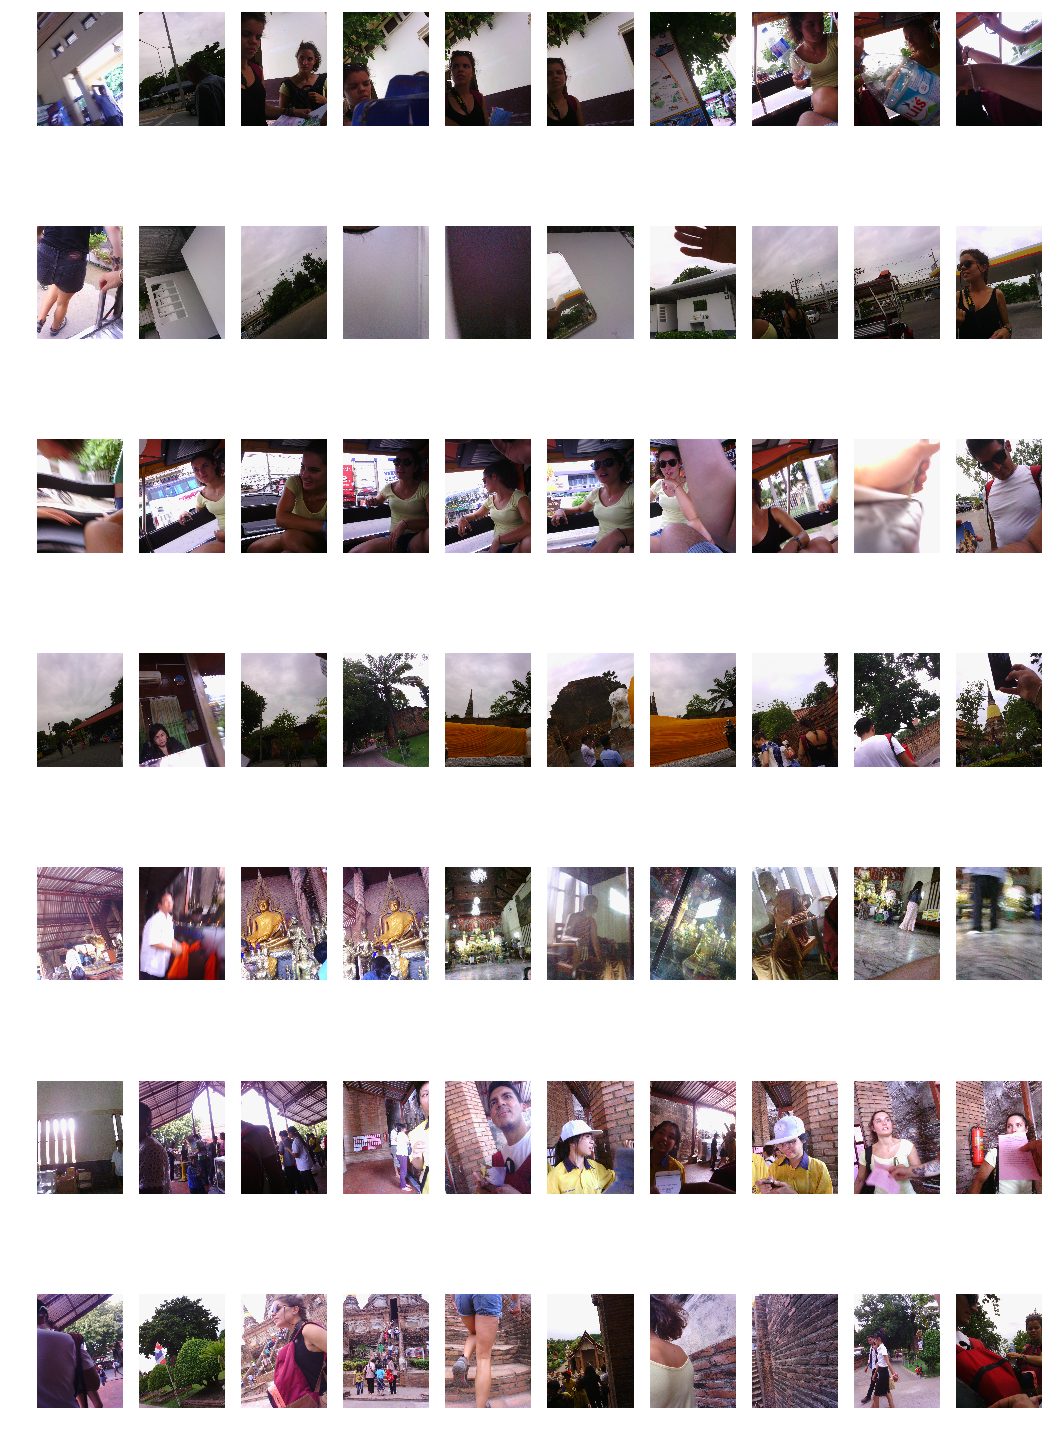

In [6]:
#selected_frames = dataset.getFramesPaths(Xdeb[0], params['INPUTS_IDS_DATASET'][0], 'train', 
#                                         params['NUM_FRAMES'], data_augmentation=False)
print Xdeb[0]
#print selected_frames


# Get list of images and list of counts
images_list = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_list.txt'
images_counts = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_counts.txt'
counts = []
imgs_list = []
with open(images_list, 'r') as fileim:
    for line in fileim:
        line = line.rstrip('\n')
        imgs_list.append(line)
with open(images_counts, 'r') as filect:
    for line in filect:
        line = line.rstrip('\n')
        counts.append(int(line))

print 
print 'Print some statistics:'
print len(counts)
num_small_segments = sum([1 if c<10 else 0 for c in counts])
print num_small_segments
print float(num_small_segments)/len(counts)
print
        
prev_im = -1
count_plotted = 1
random_sel = 10

f = plt.figure(1)
f.set_size_inches(18,30)

for im,sin,sout,l in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3]):
    if prev_im != im:
        # Plot some images
        if im == 0:
            ini_pos = 0
        else:
            ini_pos = sum(counts[:im])
        fin_pos = ini_pos + counts[im]
        current_imgs = imgs_list[ini_pos:fin_pos]
        # Pick random_sel images randomly from the event
        #random_images = sorted(np.random.choice(current_imgs, random_sel))
        # Pick them equidistantly
        random_images = [current_imgs[int(idim)] for idim in np.linspace(0,len(current_imgs)-1,random_sel)]
        # Plot images
        print
        print 'plotting event'
        print random_images
        for im_plot in random_images:
            
            im_plot = pilimage.open(dataset.path+im_plot)
            #im_plot = im.convert('RGB')
            im_plot = np.asarray(im_plot)

            ax = plt.subplot(8,random_sel,count_plotted)
            plt.imshow(im_plot)
            plt.axis('off')
            count_plotted += 1
        
    print im,':',sin,'['+str(l)+'] -->',sout
    prev_im = im

In [70]:
set_split = 'train'
[Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, range(2000,2050), debug=True)
[X, Y] = dataset.getXY_FromIndices(set_split, range(2000,2050),normalization=False, meanSubstraction=False, dataAugmentation=False)

[239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244]

plotting event
['Images/Maya5/20160610_125520_000.jpg', 'Images/Maya5/20160610_130157_000.jpg', 'Images/Maya5/20160610_130853_000.jpg', 'Images/Maya5/20160610_131549_000.jpg', 'Images/Maya5/20160610_132258_000.jpg', 'Images/Maya5/20160610_132922_000.jpg', 'Images/Maya5/20160610_133618_000.jpg', 'Images/Maya5/20160610_134327_000.jpg', 'Images/Maya5/20160610_135023_000.jpg', 'Images/Maya5/20160610_135719_000.jpg']
239 : i read in a garden [238] --> i entered in classrooms full of people
239 : i read in a garden [238] --> i entered in classrooms and talked to different people
239 : i studied in a garden of a university [238] --> i walked between two classrooms
239 : i studied in a garden of a university [238] --> i entered in classrooms full

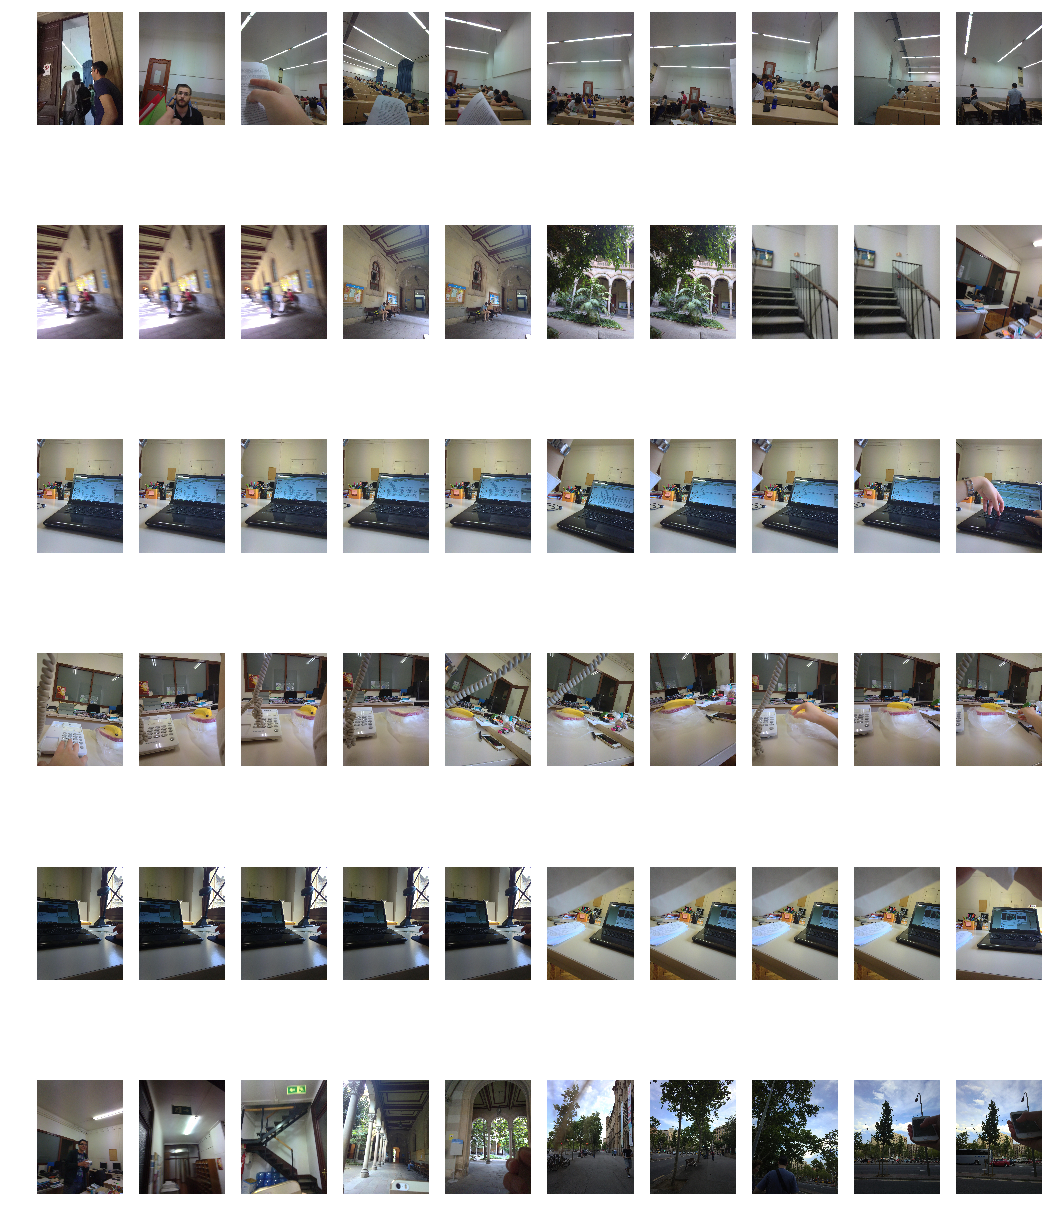

In [72]:
#selected_frames = dataset.getFramesPaths(Xdeb[0], params['INPUTS_IDS_DATASET'][0], 'train', 
#                                         params['NUM_FRAMES'], data_augmentation=False)
print Xdeb[0]
#print selected_frames


# Get list of images and list of counts
images_list = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_list.txt'
images_counts = '/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/'+set_split+'_imgs_counts.txt'
counts = []
imgs_list = []
with open(images_list, 'r') as fileim:
    for line in fileim:
        line = line.rstrip('\n')
        imgs_list.append(line)
with open(images_counts, 'r') as filect:
    for line in filect:
        line = line.rstrip('\n')
        counts.append(int(line))
        
prev_im = -1
count_plotted = 1
random_sel = 10

f = plt.figure(1)
f.set_size_inches(18,30)

for im,sin,sout,l in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3]):
    if prev_im != im:
        # Plot some images
        if im == 0:
            ini_pos = 0
        else:
            ini_pos = sum(counts[:im])
        fin_pos = ini_pos + counts[im]
        current_imgs = imgs_list[ini_pos:fin_pos]
        # Pick random_sel images randomly from the event
        #random_images = sorted(np.random.choice(current_imgs, random_sel))
        # Pick them equidistantly
        random_images = [current_imgs[int(idim)] for idim in np.linspace(0,len(current_imgs)-1,random_sel)]
        # Plot images
        print
        print 'plotting event'
        print random_images
        for im_plot in random_images:
            
            im_plot = pilimage.open(dataset.path+im_plot)
            #im_plot = im.convert('RGB')
            im_plot = np.asarray(im_plot)

            ax = plt.subplot(8,random_sel,count_plotted)
            plt.imshow(im_plot)
            plt.axis('off')
            count_plotted += 1
        
    print im,':',sin,'['+str(l)+'] -->',sout
    prev_im = im

In [3]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('train', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('train', range(50))

In [4]:
for im,sin,sout,l in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3]):
    print im,':',sin,'['+str(l)+'] -->',sout

0 :  [-1] --> i walked on the street
0 :  [-1] --> i walked in a park
0 :  [-1] --> i strolled in a garden
1 : i walked on the street [0] --> i entered in a building
1 : i walked on the street [0] --> i went insides
1 : i walked in a park [0] --> i entered in a building
1 : i walked in a park [0] --> i went insides
1 : i strolled in a garden [0] --> i entered in a building
1 : i strolled in a garden [0] --> i went insides
2 : i entered in a building [1] --> i walked on the street
2 : i entered in a building [1] --> i walked in the city
2 : i entered in a building [1] --> i walked in a park and on the street
2 : i went insides [1] --> i walked on the street
2 : i went insides [1] --> i walked in the city
2 : i went insides [1] --> i walked in a park and on the street
3 : i walked on the street [2] --> i entered in a room with computer
3 : i walked on the street [2] --> i went to a copy shop
3 : i walked on the street [2] --> i walked in a copy shop
3 : i walked in the city [2] --> i ent

In [72]:
for sin,sout,state_below,l in zip(X[2], Y[0][0], X[1], X[3]):
    sin = map(lambda x: dataset.vocabulary['description']['idx2words'][x], sin)
    sin = ' '.join(sin)
    sout_ = [np.argmax(w) for w in sout]
    sout = map(lambda x: dataset.vocabulary['description']['idx2words'][x], sout_)
    sout = ' '.join(sout)
    print l,':'
    print sin
    print '-->'
    print sout
    print '------'

-1 :
<unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
-1 :
<unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked in the house <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
-1 :
<unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked in the house <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
0 :
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked on the street <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
0 :
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i walked down the street <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
------
0 :
i looked at the ceiling <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-->
i looked at buildings and trees <pad> <pad

## '-linked-upperbound' dataset inspection

In [4]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('train', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('train', range(50))

In [5]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 : i looked at the ceiling --> i looked at the ceiling
0 : i looked at the ceiling --> i walked in the house
0 : i looked at the ceiling --> i walked in the house
0 : i walked in the house --> i looked at the ceiling
0 : i walked in the house --> i walked in the house
0 : i walked in the house --> i walked in the house
0 : i walked in the house --> i looked at the ceiling
0 : i walked in the house --> i walked in the house
0 : i walked in the house --> i walked in the house
1 : i walked on the street --> i walked on the street
1 : i walked on the street --> i walked down the street
1 : i walked on the street --> i looked at buildings and trees
1 : i walked down the street --> i walked on the street
1 : i walked down the street --> i walked down the street
1 : i walked down the street --> i looked at buildings and trees
1 : i looked at buildings and trees --> i walked on the street
1 : i looked at buildings and trees --> i walked down the street
1 : i looked at buildings and trees --> 

## '-linked-upperbound-copy' dataset inspection

In [5]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(50))

In [6]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 : error --> error
1 : i drove my car --> i drove my car
2 : i walked on the street --> i walked on the street
3 : i entered in the train station and waited for it --> i entered in the train station and waited for it
4 : i was inside a train --> i was inside a train
5 : i left the station --> i left the station
6 : i walked on the street and entered in a building --> i walked on the street and entered in a building
7 : i went to my office --> i went to my office
8 : i used my laptop --> i used my laptop
9 : i went ot the bathroom --> i went ot the bathroom
10 : i worked with my laptop --> i worked with my laptop
11 : i walked in a building --> i walked in a building
12 : i worked at a table with a laptop --> i worked at a table with a laptop
13 : i used my laptop and a computer --> i used my laptop and a computer
14 : i went to the bathroom --> i went to the bathroom
15 : i went to my office --> i went to my office
16 : i worked in a library --> i worked in a library
17 : i went to my

## '-linked-upperbound-prev' dataset inspection

In [5]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(50))

In [6]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 :  --> i was in a car with other people looking at a map
1 : i was in a car with other people looking at a map --> i entered in the reception
1 : i looked at a map and a notebook while travelling by car --> i entered in the reception
1 : i was sitting in a car with other people while reading a notebook and a map --> i entered in the reception
2 : i entered in the reception --> i was at the terrace of the hotel
2 : i entered in the hotel --> i was at the terrace of the hotel
2 : i was at a hotel --> i was at the terrace of the hotel
3 : i was at the terrace of the hotel --> i walked around the hotel
3 : i was talking with people at the terrace --> i walked around the hotel
3 : i looked at the map while being at the terrace of a hotel --> i walked around the hotel
4 : i walked around the hotel --> i looked at the surroundings
4 : i went to my hotel room --> i looked at the surroundings
4 : i was in a hotel --> i looked at the surroundings
5 : i looked at the surroundings --> i went to 

## '-linked-upperbound-nocopy' dataset inspection

In [3]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(50), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(50))

In [4]:
for im,sin,sout in zip(Xdeb[0],Xdeb[2],Ydeb[0]):
    print im,':',sin,'-->',sout

0 :  --> i was in a car with other people looking at a map
1 : i was in a car with other people looking at a map --> i entered in the reception
1 : i looked at a map and a notebook while travelling by car --> i entered in the reception
1 : i was sitting in a car with other people while reading a notebook and a map --> i entered in the reception
2 : i entered in the reception --> i was at the terrace of the hotel
2 : i entered in the hotel --> i was at the terrace of the hotel
2 : i was at a hotel --> i was at the terrace of the hotel
3 : i was at the terrace of the hotel --> i walked around the hotel
3 : i was talking with people at the terrace --> i walked around the hotel
3 : i looked at the map while being at the terrace of a hotel --> i walked around the hotel
4 : i walked around the hotel --> i looked at the surroundings
4 : i went to my hotel room --> i looked at the surroundings
4 : i was in a hotel --> i looked at the surroundings
5 : i looked at the surroundings --> i went to 

In [6]:
len(dataset.vocabulary['description']['idx2words'])

15000

## '-linked-upperbound-video' dataset inspection

In [3]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('val', range(10), debug=True)
[X, Y] = dataset.getXY_FromIndices('val', range(10))

In [16]:
paths = dataset.paths_frames['prev_description']['test']
counts = dataset.counts_frames['prev_description']['test']

In [17]:
print len(counts)
print len(paths)
print len(dataset.X_test['prev_description'])
print dataset.len_test


187
5224
187
187


## Plot lifelogging day

In [10]:
params['DATASET_NAME'] = 'EDUB-SegDesc_features-linked' #'EDUB-SegDesc_features-linked-video'
params['REBUILD_DATASET'] = False
dataset = build_dataset(params)

In [105]:
def plotEvents(ini_img, fin_img, dataset, models=[], 
               prediction_labels=[], predictions=[],
               img_per_row=10, width='150px', show_sentences=True,
               data_path='/media/HDD_3TB/DATASETS/EDUB-SegDesc/Annotations/',
               rotate_imgs=False):

    set_split = 'test'
    
    descriptions = [dataset.extra_variables['test']['description'][i] for i in range(ini_img, fin_img)]
    [Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, range(ini_img,fin_img), debug=True)
    if predictions:
        these_predictions = [predictions[p] for p in range(ini_img, fin_img)]
    #[X, Y] = dataset.getXY_FromIndices(set_split, range(ini_img,fin_img), normalization=False, meanSubstraction=True, dataAugmentation=False)

    # Get list of images and list of counts
    images_list = data_path+'/'+set_split+'_imgs_list.txt'
    images_counts = data_path+'/'+set_split+'_imgs_counts.txt'
    counts = []
    imgs_list = []
    with open(images_list, 'r') as fileim:
        for line in fileim:
            line = line.rstrip('\n')
            imgs_list.append(line)
    with open(images_counts, 'r') as filect:
        for line in filect:
            line = line.rstrip('\n')
            counts.append(int(line))

    prev_im = -1
    count_plotted = 1
    random_sel = img_per_row

    display_txt = ''
    
    #for im,sin,sout,l, im_test, y_test, idx in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3], X[0], Y[0], range(ini_img,fin_img)):
    #for im,sin,sout,l in zip(Xdeb[0],Xdeb[2],Ydeb[0], Xdeb[3]):
    for im, sout, preds in zip(Xdeb[0], descriptions, these_predictions):
        if prev_im != im:
            
            # Predict output for each model
            if models:
                
                raise NotImplementedError()
                
                # Modify dataset keeping only one test sample
                modified_dataset = copy.copy(dataset)
                for k in modified_dataset.X_test.keys():
                    if modified_dataset.X_test[k]:
                        modified_dataset.X_test[k] = modified_dataset.X_test[k][idx]
                for k in modified_dataset.Y_test.keys():
                    if modified_dataset.Y_test[k]:
                        modified_dataset.Y_test[k] = modified_dataset.Y_test[k][idx]
                modified_dataset.len_test = 1
                
                for m in models:
                    """
                    params_prediction = {'batch_size': self.batch_size,
                                     'n_parallel_loaders': self.extra_vars['n_parallel_loaders'],
                                     'predict_on_sets': [s],
                                     'pos_unk': False,
                                     'heuristic': 0,
                                     'mapping': None}
                    """
                    #params_prediction.update(checkDefaultParamsBeamSearch(self.extra_vars))
                    predictions = m.predictBeamSearchNet(modified_dataset)['test']
            
            all_sent = []
            display_txt += '<tr>'
            
            # Plot some images
            if im == 0:
                ini_pos = 0
            else:
                ini_pos = sum(counts[:im])
            fin_pos = ini_pos + counts[im]
            current_imgs = imgs_list[ini_pos:fin_pos]
            
            # Pick random_sel images randomly from the event
            #random_images = sorted(np.random.choice(current_imgs, random_sel))
            
            # Pick them equidistantly
            random_images = [current_imgs[int(idim)] for idim in np.linspace(0,len(current_imgs)-1,random_sel)]
            random_images = list(set(random_images))
            
            # Plot images
            for im_plot in random_images:

                tmp_path = 'tmp/'+str(count_plotted)+'.jpg'
                src_path = dataset.path+im_plot
                if not rotate_imgs:
                    shutil.copyfile(src_path, tmp_path)
                else:
                    im_tmp = pilimage.open(src_path)
                    im_tmp = im_tmp.rotate(90)
                    im_tmp.save(tmp_path)
                    
                # Display image
                display_txt += '<td style="border: 0px; padding-left=0.2em; width: '+width+'; height: '+width+';"><img src="'+tmp_path+'?'+str(np.random.rand())+'" style="width: '+width+';"/></td>'
                #display_txt += '<td colspan="'+str(per_row)+'" style="border: 0px; border-bottom: 1px black solid; width: '+width+';"><br><b>Ingredient activation</b>: '+max_common_ingredient_pred_name+'</td>'

                count_plotted += 1

            display_txt += '</tr>'
            
            if show_sentences:
                display_txt += '<tr><td style="border: 0px;"><b>GT</b>:</td></tr>'
           
        if show_sentences:
            #sent = im,':',sin,'['+str(l)+'] -->',sout
            for sent in sout:
                if sent not in all_sent:
                    display_txt += '<tr><td style="border: 0px;" colspan="'+str(img_per_row)+'">'+str(sent)+'</td></tr>'
                    all_sent.append(sent)
                    
        if predictions:          
            for pred_name,p in zip(prediction_labels, preds):
                display_txt += '<tr><td style="border: 0px;" colspan="'+str(img_per_row)+'"><b>'+pred_name+'</b>: '+p+'</td></tr>'

        prev_im = im
        
    display(HTML(display_txt))

In [108]:
model_names=['ABiViRNet/test_iteration_750.pred',
             'TMA_previous-caption/test_iteration_500.pred',
             'TMA_previous-video_MSVD/test_iteration_700.pred', # (BEST MODEL)
             ]

out_sentences = {}

## Open file with output results
for out_file in model_names:
    
    out_file_location = 'results/'+out_file
    with open (out_file_location, 'r') as out_file:
        for i,line in enumerate(out_file):
            line = line.rstrip('\n')
            if i not in out_sentences:
                out_sentences[i] = []
            out_sentences[i] += [line]

In [111]:
m_names = []
for m in model_names:
    m_names.append(m.split('/')[0])

print dataset.name
ini_img = 0
#fin_img = 243
fin_img = 243
plotEvents(ini_img, fin_img, dataset, 
           prediction_labels=m_names, predictions=out_sentences,
           show_sentences=True, rotate_imgs=False)

EDUB-SegDesc_features-linked-video


## Plot prediction results

In [46]:
idx = 5
modified_dataset = copy.copy(dataset)
for k in modified_dataset.X_test.keys():
    if modified_dataset.X_test[k]:
        modified_dataset.X_test[k] = modified_dataset.X_test[k][idx]
for k in modified_dataset.Y_test.keys():
    if modified_dataset.Y_test[k]:
        modified_dataset.Y_test[k] = modified_dataset.Y_test[k][idx]
modified_dataset.len_test = 1

In [47]:
predictions = model.predictBeamSearchNet(modified_dataset)['test']

KeyError: 'source_text'

In [48]:
[Xdeb, Ydeb] = dataset.getXY_FromIndices('test', range(5), debug=True)

In [49]:
print Xdeb[0]
print Xdeb[1]
print Xdeb[2]

[0, 1, 2, 3, 4]
[[], [], [], [], []]
[0, 1, 2, 3, 4]


In [50]:
[X, Y] = dataset.getXY_FromIndices('test', range(5), dataAugmentation=False)

In [51]:
len(X)

3

In [63]:
print X[0][0].shape
print X[0][0][0][:10]
print X[2][1][0][:10]

(26, 1024)
[ 1.196      0.         0.35494    0.         0.0039037  0.         0.5717
  0.         0.018406   0.90744  ]
[ 1.196      0.         0.35494    0.         0.0039037  0.         0.5717
  0.         0.018406   0.90744  ]
